<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
! pip install -q pandarallel

## Подготовка

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, notebook
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import warnings
import numpy as np
import re
import seaborn as sns
import nltk
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
warnings.filterwarnings('ignore')

In [4]:
nltk.download("stopwords") # поддерживает удаление стоп-слов
nltk.download('punkt') # делит текст на список предложений
nltk.download('wordnet')# проводит лемматизацию
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

**Загрузили дополнительную библиотеку для параллельной обработки датасета, подключили все необхоимые инструменты.**

In [5]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('toxic_comments.csv')

In [6]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [8]:
data = data.drop('Unnamed: 0', axis=1)

**Загрузили данные, посмотрели их структуру и общую информацию.**

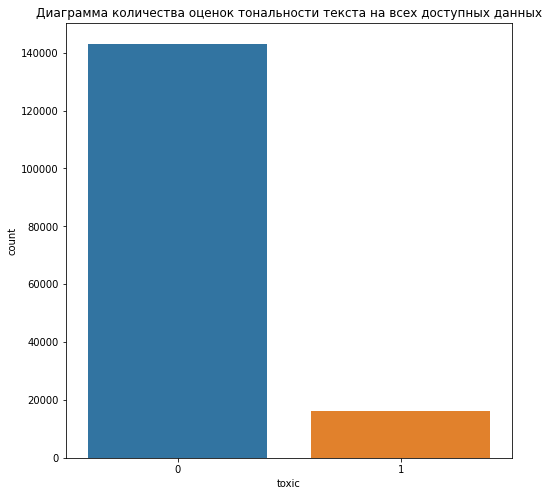

In [9]:
plt.figure(figsize=(8, 8))
sns.countplot(data=data, x="toxic")
plt.title('Диаграмма количества оценок тональности текста на всех доступных данных')
plt.show()

**Из полученной диаграммы получаем, что негативных комментариев намного меньше, чем положительных. Отсюда можно сказать, что при обучении модели необходимо задать особый параметр, отвечающий за сбалансированность классов, а также попробовать найти соответсвующий порог разделения классов.**

In [10]:
# Функция для получения правильных частей речи для лемматизатора
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ  # прилагательное
    elif tag.startswith('V'):
        return wordnet.VERB  # глагол
    elif tag.startswith('N'):
        return wordnet.NOUN  # существительное
    elif tag.startswith('R'):
        return wordnet.ADV  # наречие
    else:
        return wordnet.NOUN

In [11]:
def preprocess_comment(comment):
    # Приведение к нижнему регистру и удаление неалфавитных символов
    coment = comment.lower()
    comment = re.sub(r'[^a-zA-Z]', ' ', comment)
    
    # Токенизация
    tokens = word_tokenize(comment)
    
    # POS-теггинг (части речи)
    pos_tags = nltk.pos_tag(tokens)
    
    # Лемматизация с учетом частей речи
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    
    return ' '.join(tokens)


In [12]:
data_sample = data.sample(n=50000, random_state=42)

**Для достижения нужного качества модели можно попробовать воспользоваться не всеми представленными данными, так как  кроме качества важна скорость обучения. Возьмем 50_000 рандомных строк.**

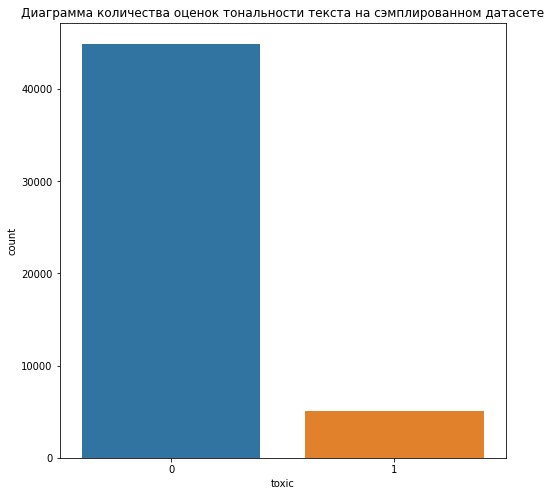

In [13]:
plt.figure(figsize=(8, 8))
sns.countplot(data=data_sample, x="toxic")
plt.title('Диаграмма количества оценок тональности текста на сэмплированном датасете')
plt.show()

**Распределение классов в сэмплированном датасете не изменилась.**

In [14]:
data_sample['processed_comments'] = data_sample['text'].parallel_apply(lambda x: preprocess_comment(x))

**Используем выше написанную функцию для подготовки текста, которая включает: удаление не алфавитных символов, лемматизацию(приведение слов к начальной форме) и токенизацию, но по итогу все равно в конечном итоге мы получим ту же самую строку, только обработанную.**

In [15]:
data_sample.head()

,text,toxic,processed_comments
31015,"Sometime back, I just happened to log on to ww...",0,Sometime back I just happen to log on to www i...
102832,"""\n\nThe latest edit is much better, don't mak...",0,The late edit be much good don t make this art...
67317,""" October 2007 (UTC)\n\nI would think you'd be...",0,October UTC I would think you d be able to get...
81091,Thanks for the tip on the currency translation...,0,Thanks for the tip on the currency translation...
90091,I would argue that if content on the Con in co...,0,I would argue that if content on the Con in co...


In [16]:
X = data_sample['processed_comments']
y = data_sample['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

**Разделим данные на таргет и признаки, а также на тестовую и тренировочную выборки, для того, чтобы векторизатор обучить на train, а потом трансформировать тестовые.**

In [17]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
#преобразуем текст
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

**Общий вывод: В данном шаге произведена подготовка текста к обучению, а именно взяли уменьшенный датасет, данные из него прошли лемматизацию, токенизацию и удаление не алфавитных символов. Данные разделены на тестовую и обучающую выборки. Векторизовали данные с помощью TfidfVectorizer.**

## Обучение модели

In [18]:
pipeline = Pipeline([ 
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

In [19]:
param_distributions = [
    {
        'classifier': [DecisionTreeClassifier(random_state=42)],
        'classifier__max_depth': range(1, 10, 3),  # Глубина дерева
        'classifier__min_samples_split': range(2, 10, 2),  # Минимальное количество образцов для разделения
    },
    {
        'classifier': [LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)],
        'classifier__C': range(5, 15, 5),  # Регуляризация C
        'classifier__penalty': ['l1', 'l2'],  # Тип регуляризации
    },
    {
        'classifier': [SVC(random_state=42)],
        'classifier__C': range(1, 10, 3),  # Регуляризация C
        'classifier__kernel': ['linear', 'rbf'],  # Тип ядра
    }
]

In [20]:
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions, 
    n_iter=10,  
    scoring='f1', 
    n_jobs=-1,  
    cv=5,  
    random_state=42
)

In [21]:
# Обучение модели и подбор гиперпараметров
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000,
                                                                 random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'classifier': [DecisionTreeClassifier(random_state=42)],
                                         'classifier__max_depth': range(1, 10, 3),
                                         'classifier__min_samples_split': range(2, 10, 2)},
                                        {'classifier': [LogisticRegression(C=5,
                                                                           class_weight='balanced',
                                                                           random_state=42,
                                                                           solver='l

In [22]:
# Вывод результатов
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший результат на кросс-валидации: {random_search.best_score_:.4f}")

Лучшие параметры: {'classifier__penalty': 'l2', 'classifier__C': 5, 'classifier': LogisticRegression(C=5, class_weight='balanced', random_state=42,
                   solver='liblinear')}
Лучший результат на кросс-валидации: 0.7440


**На кросс-валидации получаем лучшую модель - Логистическую регрессию и лучшую метрику на кросс-валидации 0.744.**

In [23]:
best_model = random_search.best_estimator_

In [24]:
test_predictions = best_model.predict(X_test)
f1 = f1_score(y_test, test_predictions)
print(f'F1-score: {round(f1, 3)}')

F1-score: 0.756


**При тестировании лучшей модели на тестовой выборке получаем метрику 0.756, что удовлетворяет условию задачи.**

In [25]:
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

In [26]:
test_predictions_dummy = dummy.predict(X_test)
f1 = f1_score(y_test, test_predictions_dummy)
print(f'F1-score: {f1}')

F1-score: 0.10861983059292477


**Вывод: Обучена модель Логистической регрессии, удовлетворяющая заданной метрике. Итоговая метрика получилась равной 0.756 на тестовой выборке. Также обучена модель Dummy, которая дает метрику f1_score 0.108, при настройках случайной классификации.**

## Выводы

В ходе данного проекта была выполнена подготовка данных и обучение модели для классификации комментариев на положительные и негативные. Были подключены необходимые библиотеки, включая библиотеку для параллельной обработки данных, что ускорило предобработку текста. После анализа структуры данных было выявлено, что негативных комментариев существенно меньше, что потребовало применения методов балансировки классов и подбора порога для разделения.

Для оптимизации времени обучения был выбран уменьшенный датасет размером в 50 000 случайных строк. Использованная функция предобработки текста выполнила лемматизацию, токенизацию и удаление неалфавитных символов, преобразовав комментарии в строки, подготовленные для дальнейшего анализа. Данные были разделены на тренировочную и тестовую выборки. Векторизация текста была выполнена с помощью `TfidfVectorizer`, что позволило преобразовать текст в числовые признаки.

Основной моделью для обучения была Логистическая регрессия на кросс-валидации с лучшей метрикой 0.744 Результаты модели на тестовой выборке показали следующие числовые значения метрик:
- **f1_score**: 0.756

Дополнительно была обучена базовая модель Dummy, которая показала метрику f1_score равную 0.108. Это подтверждает, что Логистическая регрессия продемонстрировала значительно лучшие результаты и является адекватным выбором для задачи.

Таким образом, итоговая модель Логистической регрессии показала хорошие результаты и удовлетворяет заданным требованиям по качеству.